# Gaussian Process Regression

Now we'll experiment with Gaussian Processes.
First, let's import our dependencies and generate the synthetic dataset, like we did in the Bayesian Linear Regression notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from core import generate_dataset, plot_with_error_regions

In [57]:
DATASET_SIZE = 100
X_RANGE = [-4*np.pi, 4*np.pi]

dataset = generate_dataset(DATASET_SIZE, X_RANGE, lambda x: np.sin(0.5*x))
dataset_x = dataset[0]
dataset_y = dataset[1]

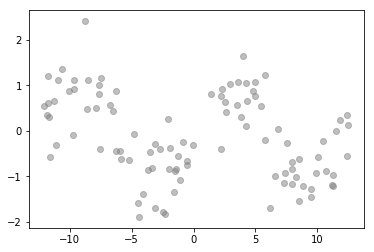

In [58]:
plt.scatter(dataset_x, dataset_y, color='grey', alpha=0.5)
plt.show()

## Theory of Gaussian Processes

A Gaussian Process represents a distribution over a set of random variables (called the index set) where the joint distribution over any finite subset of these variables is Gaussian.  For the purpose of our study, the index set represents the domain of the function that we're trying to learn.

Since we're essentially modelling a very high-dimensional Gaussian distribution, the system is characterized by a mean and a covariance. For simplicity, we take the prior mean to be $0$, and we describe the covariance by a covariance function, which we'll refer to as a *kernel*.

More specifically, we're trying to model some function $f:\mathcal{X}\rightarrow\mathbb{R}$, where $\mathcal{X}$ is the index set. We write

$$f\sim\mathcal{GP}(\mathbf{0}, k)$$

where $k: \mathcal{X}\times\mathcal{X}\rightarrow\mathbb{R}$ is the kernel function. Assume we take a subset of $\mathcal{X}$ and partition it into training points and test points, so it looks like $(\mathbf{x}, \overline{\mathbf{x}})^T$ where $\mathbf{x}$ denotes the partition of training points, and $\overline{\mathbf{x}}$ denotes the partition of testing points. Assume there are $n$ training points and $\overline{n}$ test points. Since this is modeled as a Gaussian process, we have:

$$
\begin{bmatrix}\mathbf{f}(\mathbf{x})\\\mathbf{f}(\overline{\mathbf{x}})\end{bmatrix}\sim\mathcal{N}(\mathbf{0},K)
$$

The matrix $K$ is determined as follows:

$$
K\triangleq\begin{bmatrix}K(X, X) & K(X, \overline{X})\\K(\overline{X},X) & K(\overline{X},\overline{X})\end{bmatrix} \triangleq\begin{bmatrix}A & B\\C &D\end{bmatrix}
$$

The blocks in this matrix are derived from the kernel function. The $K(X,X)$ block is an $n\times n$ matrix where $K(X, X)_{ij} = k(\mathbf{x}_i,\mathbf{x}_j) \ \forall i,j\in\{1,\dots, n\}$. Likewise, $K(X, \overline{X})\in\mathbb{R}^{n\times\overline{n}}$ satisfies $K(X,\overline{X})_{ij} = k(\mathbf{x}_i, \overline{\mathbf{x}}_j) \ \forall i\in\{1,\dots,n\}\forall j\in\{1,\dots, \overline{n}\}$. The remaining two blocks follow the same pattern.

The goal now is to determine the predictive distribution over the test point targets, namely

$$p(\mathbf{f}(\overline{\mathbf{x}}) | \overline{\mathbf{x}}, \mathbf{f}(\mathbf{x}), \mathbf{x})$$

Since the Gaussian Process definition ensures that the joint distribution of every finite subset of index variables is Gaussian, we can obtain this predictive distribution by conditioning on $\mathbf{f}(\mathbf{x})$. Recall that for a joint Gaussian distribution with

$$
\begin{bmatrix}\mathbf{x}\\\mathbf{y}\end{bmatrix}\sim\mathcal{N}\left(\begin{bmatrix}\mathbf{a}\\\mathbf{b}\end{bmatrix}, \begin{bmatrix}A &B\\C &D\end{bmatrix}\right)
$$

the conditional distribution of $\mathbf{y}$ given $\mathbf{x}$ is given by

$$\mathbf{y}|\mathbf{x}\sim\mathcal{N}\left(\mathbf{b} + CA^{-1}(\mathbf{x}-\mathbf{a}), D - CA^{-1}B\right)$$

Therefore, our predictive distribution over the test targets is

$$\mathbf{f}(\overline{\mathbf{x}})|\mathbf{f}(\mathbf{x})\sim\mathcal{N}\left(K(\overline{X},X)K(X, X)^{-1}\mathbf{f}(\mathbf{x}), K(\overline{X},\overline{X}) - K(\overline{X},X)K(X, X)^{-1}K(X, \overline{X})\right)$$

### The Kernel Function

The kernel function $k: \mathcal{X}\times\mathcal{X}\rightarrow\mathbb{R}$ plays an important role in the Gaussian Process model. Essentially, this function specifies how correlated two variables from the index set should be. A common kernel that is used has the following form:

$$k(\mathbf{x}, \mathbf{x}') = \exp\left(\frac{1}{2\ell}|\mathbf{x}-\mathbf{x}'|^2\right)$$

With this kernel, variables that are closer together in Euclidean distance are more highly correlated, so the corresponding target values are likely to be similar. Consider a problem where $\mathcal{X}=\mathbb{R}$, so we are learning a single variable function. This kernel is saying that for two values $x,x'$ that are near, the corresponding $f(x),f(x')$ are highly-correlated, and shouldn't differ much from one another. Intuitively, this kernel encourages the GP to generate smooth functions.

We could also, for instance, derive a periodic kernels that correlates variables that are both near each other, and near a periodic offset somehow.

## Implementing a Gaussian Process Regressor

In [59]:
class GaussianProcessRegressor:
    def __init__(self, kernel, sn):
        self._kernel = kernel
        self._sn = sn
        
    def fit(self, x, f):
        k11 = np.zeros((len(x), len(x)))
        for i in range(len(x)):
            for j in range(len(x)):
                k11[i][j] = self._kernel(x[i],x[j])
        k11 += self._sn * np.eye(len(x))
        self._k11_inv = np.linalg.inv(k11)
        self._k11_inv_f = self._k11_inv.dot(f)
        self._train_x = x
        self._train_f = f
        
    def prediction_params(self, x):
        k21 = np.zeros((len(x), len(self._train_x)))
        k22 = np.zeros((len(x), len(x)))
        for i in range(len(x)):
            for j in range(len(self._train_x)):
                k21[i][j] = self._kernel(x[i], self._train_x[j])
            for j in range(len(x)):
                k22[i][j] = self._kernel(x[i], x[j])
        mean = k21.dot(self._k11_inv).dot(self._train_f)
        var = k22 - k21.dot(self._k11_inv).dot(k21.T)
        return mean, var
    
    def predict(self, x):
        mean, var = self.prediction_params(x)
        return np.random.multivariate_normal(mean, var)

In [60]:
def gaussian_kernel(l):
    return lambda x1,x2: np.exp(-np.linalg.norm(x1-x2) / (2*l))

regressor = GaussianProcessRegressor(gaussian_kernel(5), 0.5)

In [61]:
regressor.fit(dataset_x, dataset_y)

### Sampling from the posterior

Finished sample 1 of 4
Finished sample 2 of 4
Finished sample 3 of 4
Finished sample 4 of 4


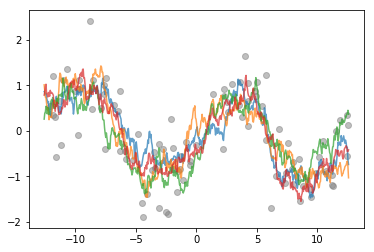

In [62]:
N_POSTERIOR_SAMPLES=4

xs = np.linspace(X_RANGE[0], X_RANGE[1], 500)

plt.scatter(dataset_x, dataset_y, color='grey', alpha=0.5)

for sample in range(N_POSTERIOR_SAMPLES):
    ys = regressor.predict(xs)
    print("Finished sample {} of {}".format(sample + 1, N_POSTERIOR_SAMPLES))
    plt.plot(xs, ys, alpha=0.7)
    
plt.show()

Let's try to make the samples smoother by increasing the $\ell$ parameter of the kernel.

In [63]:
regressor_smoother = GaussianProcessRegressor(gaussian_kernel(50), 0.5)

In [64]:
regressor_smoother.fit(dataset_x, dataset_y)

Finished sample 1 of 4
Finished sample 2 of 4
Finished sample 3 of 4
Finished sample 4 of 4


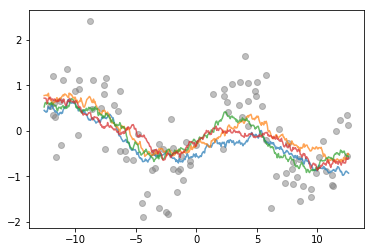

In [65]:
plt.scatter(dataset_x, dataset_y, color='grey', alpha=0.5)

for sample in range(N_POSTERIOR_SAMPLES):
    ys = regressor_smoother.predict(xs)
    print("Finished sample {} of {}".format(sample + 1, N_POSTERIOR_SAMPLES))
    plt.plot(xs, ys, alpha=0.7)
    
plt.show()

Now let's take a look at the predictive mean and variance. We'll use the less smooth regressor for now.

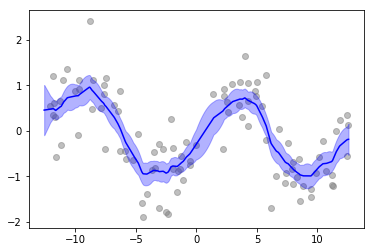

In [66]:
plt.scatter(dataset_x, dataset_y, color='grey', alpha=0.5)

mean, cov = regressor.prediction_params(xs)
variance = np.diagonal(cov)

plt.plot(xs, mean, color='blue')
plt.fill_between(xs, mean-3*variance, mean+3*variance, color='blue', alpha=0.3)
plt.show()

And now we'll try with the "smooth" regressor...

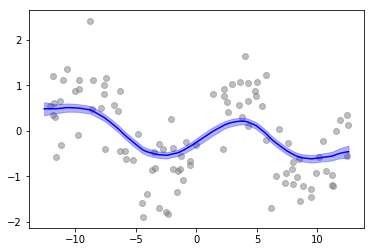

In [67]:
plt.scatter(dataset_x, dataset_y, color='grey', alpha=0.5)

mean, cov = regressor_smoother.prediction_params(xs)
variance = np.diagonal(cov)

plt.plot(xs, mean, color='blue')
plt.fill_between(xs, mean-3*variance, mean+3*variance, color='blue', alpha=0.3)
plt.show()

Like we did with in the Bayesian Linear Regression notebook, we'll observe what happens when we try to predict outside the range of the training set.

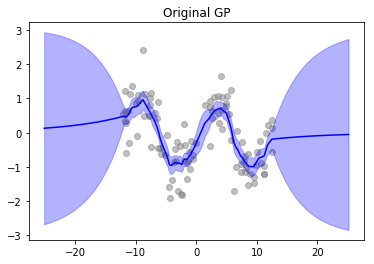

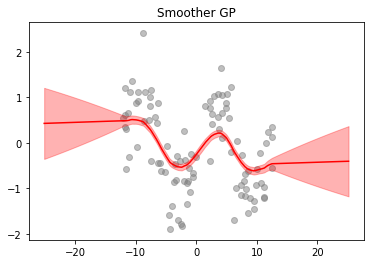

In [73]:
EXTRA_WIDTH=4*np.pi
wider_xs = np.linspace(X_RANGE[0]-EXTRA_WIDTH, X_RANGE[1] + EXTRA_WIDTH, 500)
mean, cov = regressor.prediction_params(wider_xs)
variance = np.diagonal(cov)
plt.scatter(dataset_x, dataset_y, color='grey', alpha=0.5)
plt.plot(wider_xs, mean, color='blue')
plt.fill_between(wider_xs, mean-3*variance, mean+3*variance, color='blue', alpha=0.3)
plt.title("Original GP")
plt.show()

mean, cov = regressor_smoother.prediction_params(wider_xs)
variance = np.diagonal(cov)
plt.scatter(dataset_x, dataset_y, color='grey', alpha=0.5)
plt.plot(wider_xs, mean, color='red')
plt.fill_between(wider_xs, mean-3*variance, mean+3*variance, color='red', alpha=0.3)
plt.title("Smoother GP")
plt.show()

Note that these GP models both exhibit far less variance than the Bayesian Linear Regression models.

## Some apparent Pros and Cons of Gaussian Processes

* <font color='green'>**PRO**: The GP implementation seemed to require less feature engineering than the Bayesian Linear Regression model. The kernel function seems to cover a fairly general range of datasets, whereas the polynomial projection with Bayesian Linear Regression model was a little more rigid.</font>
* <font color='green'>**PRO**: The GP implementation demonstrates very low variance.</font>
* <font color='red'>**CON**: To make use of a GP, you must store the entire dataset, which could be expensive.</font>
* <font color='red'>**CON**: Training a GP requires inverting a matrix, so it has $O(n^3)$ time complexity, which is slow. Moreover, batch predictions with GP could require large matrix multiplications, which is also slow. The Bayesian Linear Regression model was *much* faster for both training and prediction.</font>

The [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) textbook has alluded to the existence of approximation algorithms that improve the efficiency of training and predictions, however I haven't read that far yet.